# Hierarchical model for spelling performance

We analyze the data from the study `D. Thissen, Steinberg, and Wainer 1993` which can be found in the R [spelling](https://rdrr.io/cran/edstan/man/spelling.html) package

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
import arviz as az

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format='retina'

### Loading the data

In [2]:
data = pd.read_csv('spelling.csv')
data.index = data.index.rename('student')
data = data.set_index('male', append=True)
data.columns = data.columns.rename('word') 
data = data.stack().rename('correct').reset_index()
data = data.assign(word_i = data.word.astype('category').cat.codes)
data = data.assign(g = data.male - 0.5)
data.sample(5)

,student,male,word,correct,word_i,g
871,217,1,girder,0,0,0.5
834,208,1,succumb,0,3,0.5
1502,375,0,succumb,0,3,-0.5
1660,415,0,infidelity,1,1,-0.5
748,187,0,infidelity,1,1,-0.5


Each row here has information about the person id (enumerated), whether the person is male, what is the word they need to spell (enumerated as in the chart below) and if they successfully spelled it.

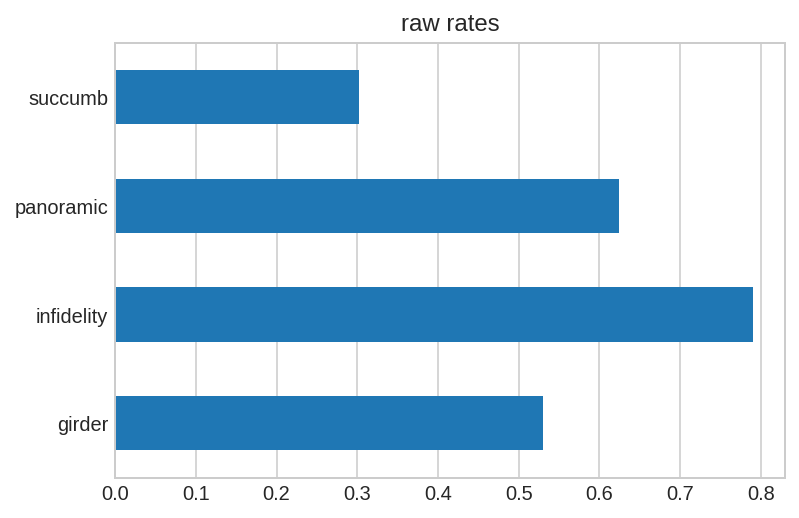

In [3]:
data.groupby('word').correct.mean().plot.barh()
plt.grid(axis='y')
plt.gca().set(
    title='raw rates',
    ylabel=''
)
None

## Model

We model the rate of spelling success as a logistic regression, where the probability of correct spelling is modeled for each individual person $i$ and word $j$:


of the individual capability of the person, as well as the word effect on the success - some words are easier to spell. Furthermore, we expect the word effect to have an interaction with the person's sex, so we use covariate effects. Both are done with a non-centered parametarization.

$$ \text{correct}_{i, j} \sim \text{Bernouilli}(p_{i, j}) $$

We split the dependence $b$ of gender $ g = 0.5 $ for male, otherwise $-0.5  $:

$$ \text{logit}(p_{i, j}) = a_{i, j} + b_{j} g $$

With the intercept, we model the individual capability $\beta$ for spelling as well as the specific word effect $\gamma$ (some words are more difficult to spell than others):

$$ a_{i, j} = \alpha + \beta_i + \gamma_j $$

Furthermore, words might have marginal effects depending on gender:

$$ b_j = \kappa + \lambda_j $$

We model both the person and word effects hierarchically with non-centered parametrization:

$$ \beta_i \sim \mathcal{N}(0, \rho) $$

$$ \gamma_j \sim \mathcal N (0, \sigma_{\gamma} ) $$

$$ \lambda_j \sim \mathcal N (0, \sigma_{\lambda} ) $$

For the hyperpriors we use:

$$ \alpha \sim \mathcal N (0, 1.5^2)$$ 

$$ \kappa \sim \mathcal N (0, 1^2) $$

$$ \rho \sim \text{Exponential}(1) $$

$$ \sigma_{\gamma} \sim \text{Exponential}(1) $$

$$ \sigma_{\lambda} \sim \text{Exponential}(1) $$

In [4]:
n_person = data.student.nunique()
n_word = data.word.nunique()

with pm.Model() as m1:
    alpha = pm.Normal('alpha', 0, 1.5)
    kappa = pm.Normal('kappa', 0, 1)

    rho = pm.Exponential('rho', 1)
    beta = pm.Normal('beta', mu=0, sd=rho, shape=n_person)

    sigma_gamma = pm.Exponential('sigma_gamma', 1)
    gamma = pm.Normal('gamma', 0, sigma_gamma, shape=n_word)
    
    sigma_lambda = pm.Exponential('sigma_lambda', 1)
    lambda_ = pm.Normal('lambda', 0, sigma_lambda, shape=n_word)

    a = alpha + beta[data.student.values] + gamma[data.word_i.values]
    b = kappa + lambda_[data.word_i.values]

    p = pm.math.invlogit(a + b * data.g.values)

    pm.Bernoulli('obs', p=p, observed=data.correct.values)

    # word rates for an average individual, by gender
    pm.Deterministic(
        'word_p',
        pm.math.invlogit(
            alpha + gamma + (kappa + lambda_) * np.array([[-0.5, 0.5]]).T
        )
    )

    trace1 = pm.sample(8000, tune=8000, chains=2)

/tmp/ipykernel_206994/1043957047.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1 = pm.sample(8000, tune=8000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, sigma_lambda, gamma, sigma_gamma, beta, rho, kappa, alpha]


Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 237 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


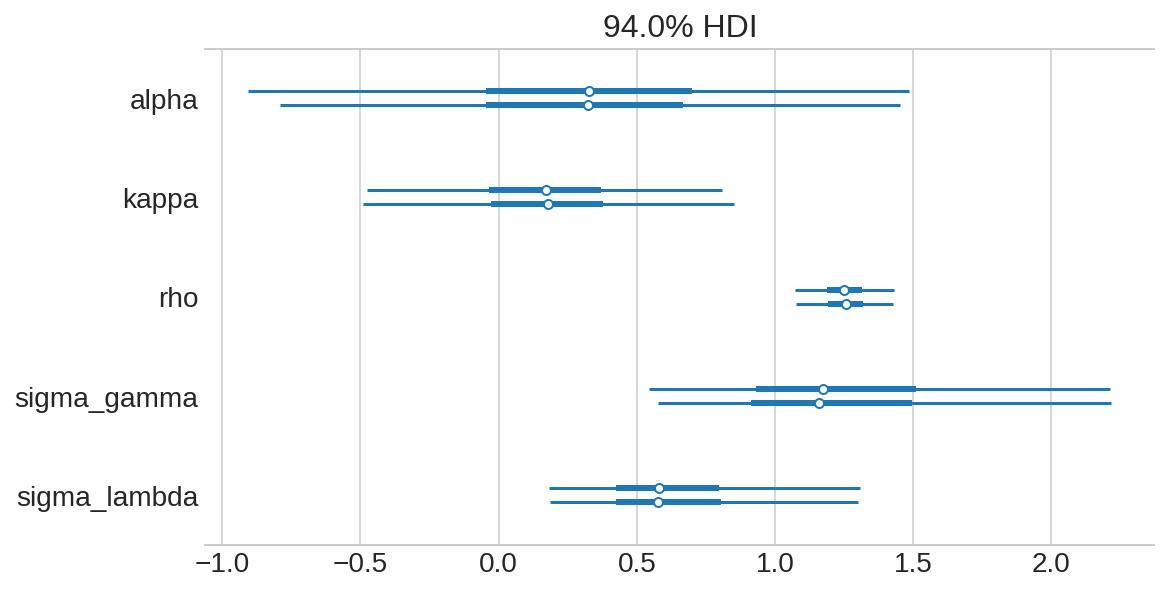

In [5]:
az.plot_forest(trace1, var_names=['alpha', 'kappa', 'rho', 'sigma_gamma', 'sigma_lambda'],
               figsize=(8, 4))
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


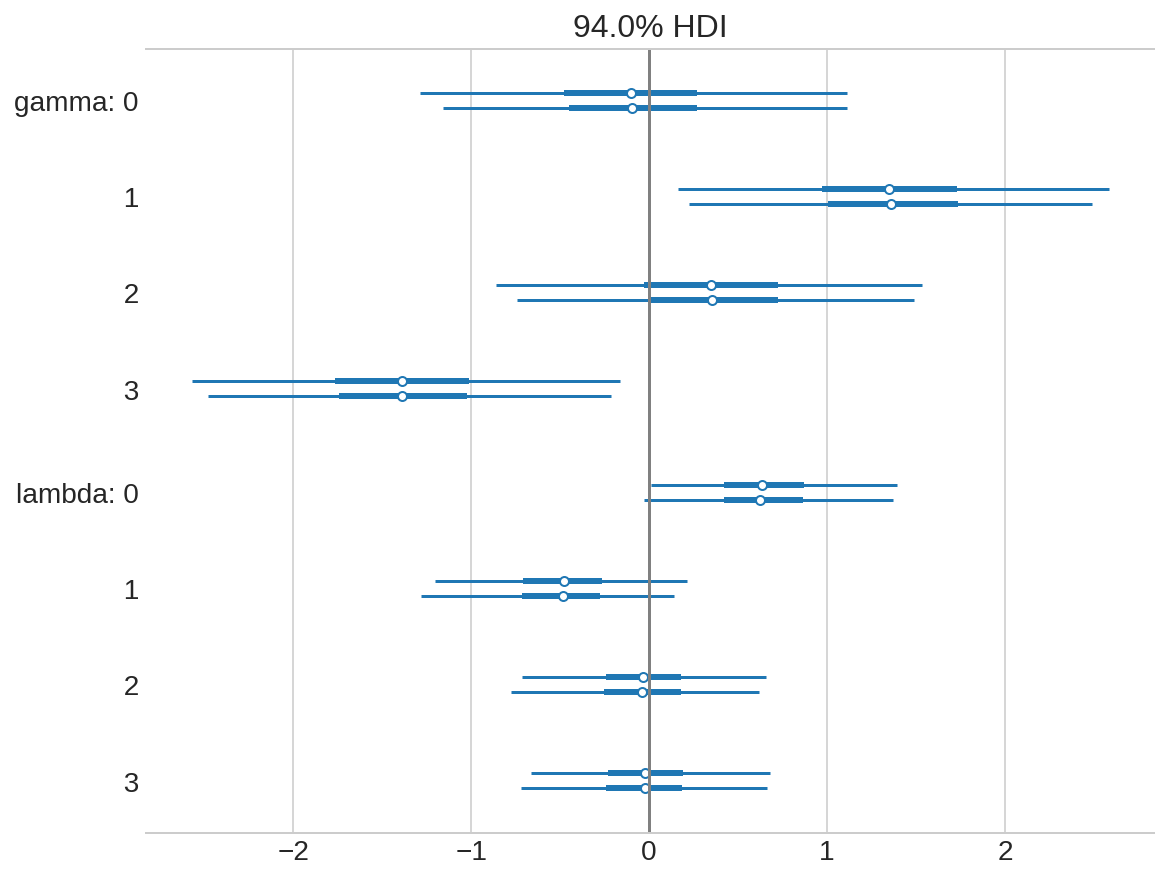

In [6]:
az.plot_forest(trace1, var_names=['gamma', 'lambda'],
               figsize=(8, 6))
plt.axvline(0, color='gray')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


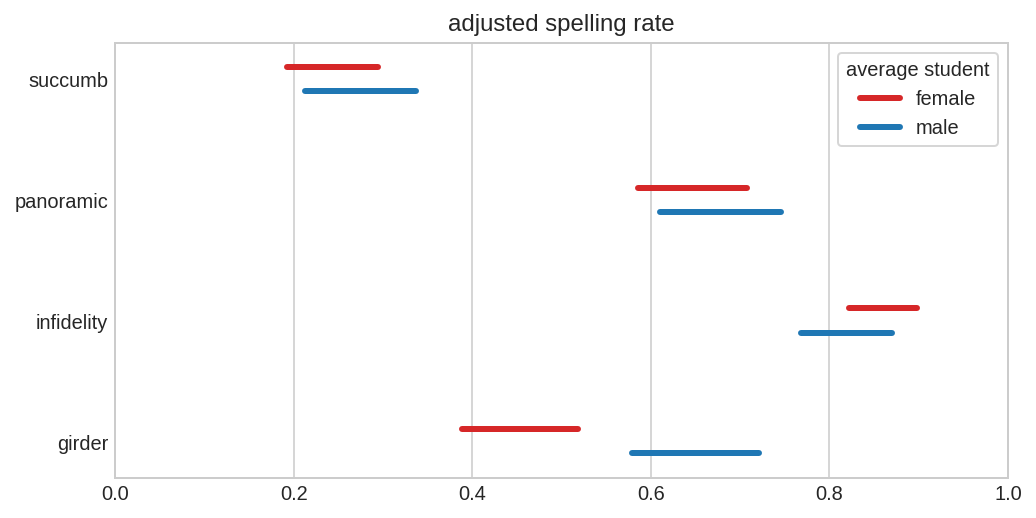

In [7]:
tmp_f = az.hdi(trace1['word_p'][:, 0, :], hdi_prob=0.95)
tmp_m = az.hdi(trace1['word_p'][:, 1, :], hdi_prob=0.95)

fig = plt.figure(figsize=(8, 4))

for y in range(4):
    labels = ['female', 'male'] if y == 0 else ['', '']
    plt.plot(tmp_f[y, :], (y + 0.1, y + 0.1), color='C3', linewidth=3, label=labels[0])
    plt.plot(tmp_m[y, :], (y - 0.1, y - 0.1), color='C0', linewidth=3, label=labels[1])

plt.gca().set(
    yticks=range(4),
    yticklabels=data[['word', 'word_i']].drop_duplicates().set_index('word_i').word.sort_index(),
    xlim=(0, 1),
    ylim=(-0.3, 3.3),
    title='adjusted spelling rate'
)

plt.grid(axis='y')
plt.legend(title='average student', frameon=True)
fig.savefig('average_actor.svg')
None